# Exogenous Causal Forest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 2000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 0.0 * X[:, [0]] + np.random.normal(0, 1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [3]:
from econml.grf import CausalForest
est = CausalForest(criterion='mse', n_estimators=4000, min_samples_leaf=5, max_depth=None,
                   min_var_leaf=0.0, min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=1, n_jobs=-1, random_state=1235)

In [4]:
%time est.fit(X, T, y.reshape(-1, 1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    8.2s


Wall time: 13 s


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:   10.3s finished


CausalForest(min_var_leaf=0.0, n_estimators=4000, random_state=1235, verbose=1)

In [5]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s


Wall time: 1.92 s


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished


In [6]:
%time point = est.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.5s


Wall time: 763 ms


[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.6s finished


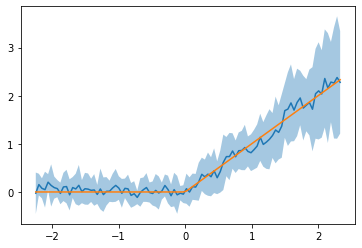

In [7]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

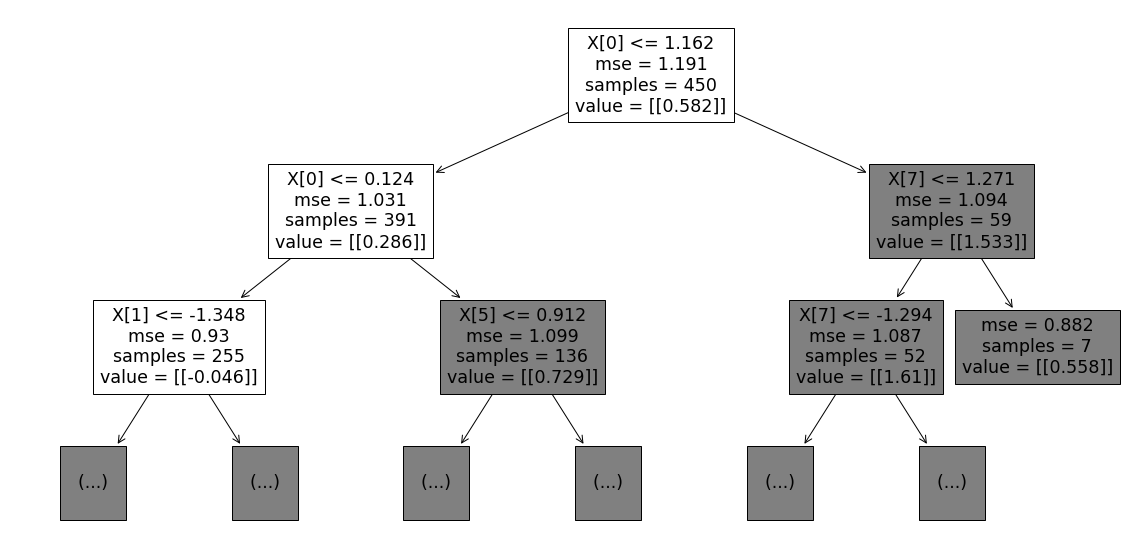

In [8]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[1], impurity=True, max_depth=2)
plt.show()

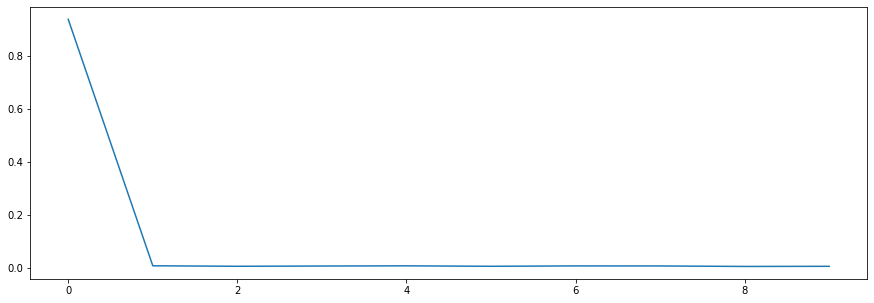

In [9]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [10]:
est.decision_path(X_test[:1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    1.1s finished


(<1x481132 sparse matrix of type '<class 'numpy.int64'>'
 	with 38878 stored elements in Compressed Sparse Row format>,
 array([     0,    111,    234, ..., 480890, 481007, 481132], dtype=int32))

In [11]:
est.apply(X_test[:1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    0.2s finished


array([[69, 18, 18, ...,  7, 27, 20]], dtype=int64)

### Running time comparison with a simple regression forest predicting the treatments

In [12]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=4000, min_samples_leaf=40, max_samples=.45, n_jobs=-1, max_depth=None, verbose=0)

In [13]:
%time rf.fit(X, np.hstack([T, T[:, [0]]]))
%time pred = rf.predict(X)

Wall time: 7.05 s
Wall time: 989 ms


### Comparison with ForestDML

In [14]:
from econml.dml import ForestDML
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
est = ForestDML(model_y=RandomForestRegressor(min_samples_leaf=100),
                model_t=RandomForestRegressor(min_samples_leaf=100),
                n_estimators=4000, min_samples_leaf=20, subsample_fr=.9,
                max_depth=100, verbose=0, n_jobs=-1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The ForestDML class has been deprecated by the CausalForestDML with parameter `criterion='mse'`; an upcoming release will remove support for the old class
  


In [15]:
%time est.fit(y, T, X=X)

C:\ProgramData\Anaconda3\lib\site-packages\econml\utilities.py:822: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X, y, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\econml\utilities.py:822: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X, y, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\econml\utilities.py:822: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X, y, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\econml\utilities.py:822: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  r

Wall time: 10.3 s


In [16]:
%time point = est.effect(X_test)

Wall time: 668 ms


In [17]:
%time lb, ub = est.effect_interval(X_test, alpha=0.01)

Wall time: 1.69 s


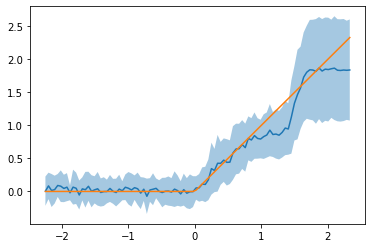

In [18]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

# IV Causal Forest

In [19]:
import numpy as np
import scipy.special
np.random.seed(1227)
n_samples = 5000
n_features = 10
n_treatments = 2
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10*U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [20]:
from econml.grf import CausalIVForest
est = CausalIVForest(criterion='mse', n_estimators=4000, min_samples_leaf=40,
                     min_var_leaf=0.01, min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [21]:
%time est.fit(X, T, y, Z=Z)

Wall time: 18.3 s


CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_leaf=0.01, n_estimators=4000, random_state=123)

In [22]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Wall time: 3.29 s


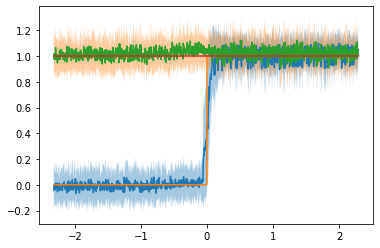

In [23]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

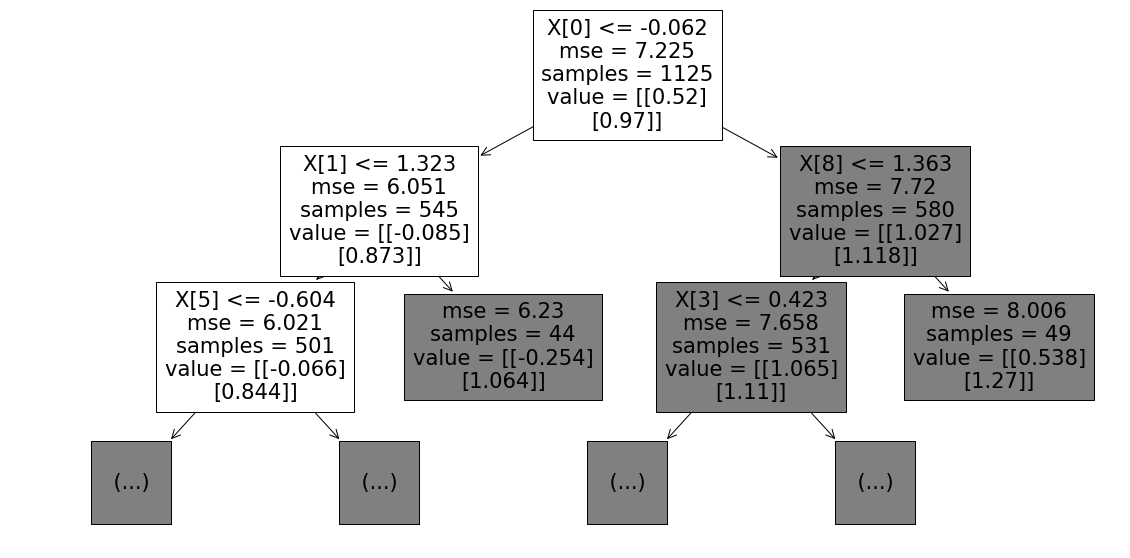

In [25]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

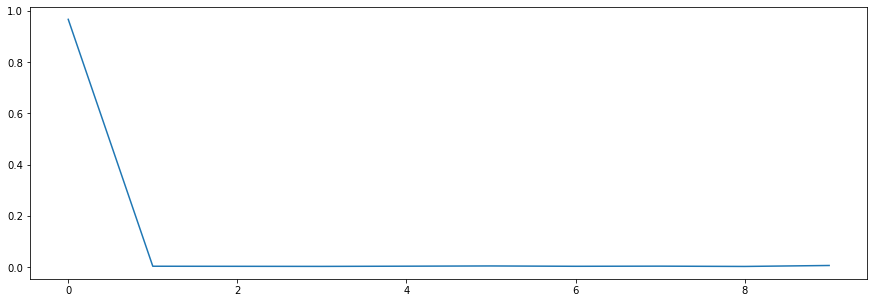

In [26]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [27]:
est[0].decision_path(X_test[:1])

<1x41 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [28]:
est[0].apply(X_test[:1])

array([12], dtype=int64)

# Regression Forest

In [29]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 2000
n_features = 10
n_outputs = 2
true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_outputs - 1))*np.arange(1, n_outputs).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
y = true_te(X) + 0.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [30]:
from econml.grf import RegressionForest
est = RegressionForest(n_estimators=4000, min_samples_leaf=5, max_depth=None,
                       min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                       warm_start=False, inference=True, subforest_size=4,
                       honest=True, verbose=1, n_jobs=-1, random_state=1235)

In [31]:
%time est.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    5.2s


Wall time: 9.44 s


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    6.7s finished


RegressionForest(n_estimators=4000, random_state=1235, verbose=1)

In [32]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s


Wall time: 1.87 s


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished


In [33]:
%time point = est.predict(X_test, interval=False, alpha=0.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.3s


Wall time: 744 ms


[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.6s finished


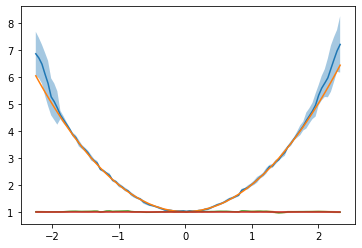

In [34]:
import matplotlib.pyplot as plt
for t in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

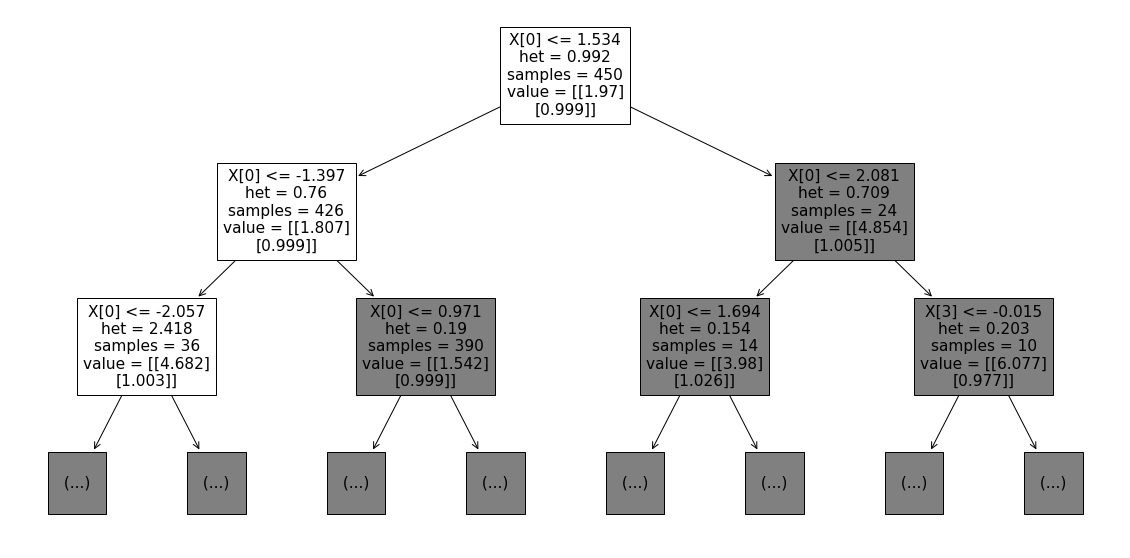

In [35]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

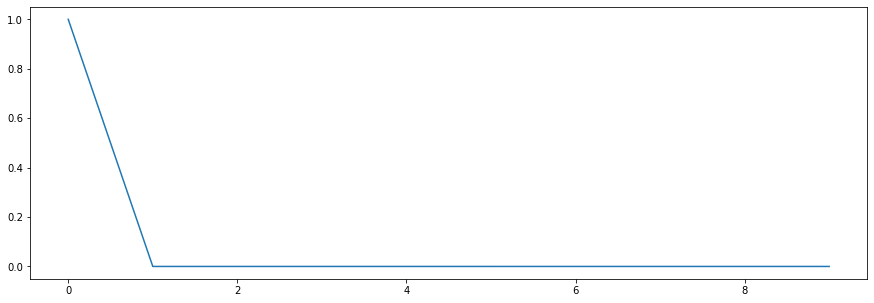

In [36]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

# Combining with DML

In [37]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 5000
n_features = 10
n_treatments = 1
n_outputs = 1
true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
W = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
# T[:, 1] = .9 * T[:, 0] + .1 * T[:, 1]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 5.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
y = np.tile(y, (1, n_outputs))
for j in range(n_outputs):
    y[:, j] = (j + 1) * y[:, j]
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [38]:
from econml.dml import CausalForestDML
est = CausalForestDML(criterion='mse', n_estimators=4000, min_var_leaf=None,
                      verbose=1, discrete_treatment=True,
                      n_jobs=-1, random_state=123).fit(y, T, X=X, W=W)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      

In [39]:
est.marginal_effect(np.ones((X_test.shape[0], n_treatments)), X_test).shape

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.9s finished


(100, 1, 1)

In [40]:
res = est.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 1000 

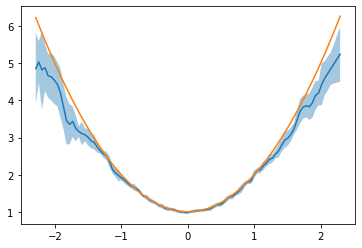

In [41]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    for j in range(n_outputs):
        plt.plot(X_test[:, 0], point[:, j, t])
        plt.fill_between(X_test[:,0], lb[:, j, t], ub[:, j, t], alpha=.4)
        plt.plot(X_test[:, 0], (j + 1) * true_te(X_test)[:, t])
plt.show()

In [42]:
res.summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
0,4.857,0.372,13.056,0.0,4.245,5.469
1,5.033,0.217,23.144,0.0,4.675,5.390
2,4.818,0.416,11.573,0.0,4.133,5.503
3,4.879,0.244,19.963,0.0,4.477,5.281
4,4.662,0.228,20.446,0.0,4.287,5.037
...,...,...,...,...,...,...
95,4.726,0.177,26.672,0.0,4.435,5.017
96,4.860,0.171,28.475,0.0,4.580,5.141
97,4.986,0.206,24.158,0.0,4.646,5.325
98,5.120,0.248,20.610,0.0,4.711,5.528


In [43]:
res = est.effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 1000 

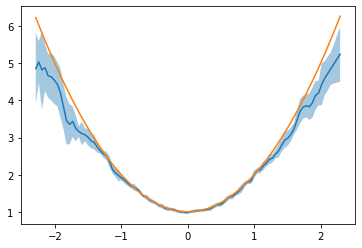

In [44]:
import matplotlib.pyplot as plt
for j in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, j])
    plt.fill_between(X_test[:,0], lb[:, j], ub[:, j], alpha=.4)
    plt.plot(X_test[:, 0], (j + 1) * np.sum(true_te(X_test), axis=1))
plt.show()

In [45]:
res.summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
0,4.857,0.372,13.056,0.0,4.245,5.469
1,5.033,0.217,23.144,0.0,4.675,5.390
2,4.818,0.416,11.573,0.0,4.133,5.503
3,4.879,0.244,19.963,0.0,4.477,5.281
4,4.662,0.228,20.446,0.0,4.287,5.037
...,...,...,...,...,...,...
95,4.726,0.177,26.672,0.0,4.435,5.017
96,4.860,0.171,28.475,0.0,4.580,5.141
97,4.986,0.206,24.158,0.0,4.646,5.325
98,5.120,0.248,20.610,0.0,4.711,5.528


In [46]:
est.feature_importances_

array([[0.98541615, 0.00243487, 0.00146408, 0.00187952, 0.00158619,
        0.00161462, 0.00145952, 0.00141992, 0.00133282, 0.0013923 ]])

#### Comparison with OrthoForest

In [49]:
from econml.ortho_forest import DMLOrthoForest
est = DMLOrthoForest(n_trees=100, subsample_ratio=.3, discrete_treatment=True).fit(y, T, X, W)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: X and W should be passed by keyword only. In a future release we will disallow passing X and W by position.
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


In [50]:
point = est.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished


In [51]:
lb, ub = est.const_marginal_effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished


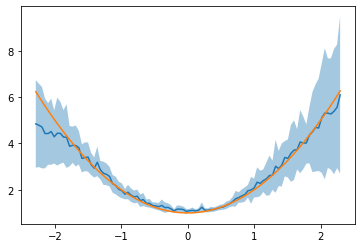

In [56]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, 0, 0])
    plt.fill_between(X_test[:,0], lb[:, 0, 0], ub[:, 0, 0], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()